### 1 Loading Dataset

In [40]:
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import os
import random
from torchvision import transforms

from models.my_datasets import MyDataset4
from models.my_models_alex2 import MyModel_CNN
#from models.my_models_alex import MyModel_CNN


In [41]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
print(device)

True
cuda:0


In [43]:
'''
ROOT = './output/town04_image_data/images/'
OUT = './output/town04_image_data/smallimages/'
SIZE = (400,300)
image_paths = os.listdir(ROOT)
image_paths.sort()
for im in image_paths:
    #print(im)
    img = cv2.imread(ROOT+im)
    img = cv2.resize(img, SIZE,  interpolation = cv2.INTER_AREA)
    cv2.imwrite(OUT+im, img)
'''

"\nROOT = './output/town04_image_data/images/'\nOUT = './output/town04_image_data/smallimages/'\nSIZE = (400,300)\nimage_paths = os.listdir(ROOT)\nimage_paths.sort()\nfor im in image_paths:\n    #print(im)\n    img = cv2.imread(ROOT+im)\n    img = cv2.resize(img, SIZE,  interpolation = cv2.INTER_AREA)\n    cv2.imwrite(OUT+im, img)\n"

In [44]:
'''
#### delete the data for the unstored images
ROOT = './output/town04_image_data/'
out = open(ROOT+"alldata.txt",'w')
lines=[]
with open(ROOT+"offdata_image.txt", 'r') as infile:
    for line in infile:
        line = line.rstrip()
        words = line.split()
        img = cv2.imread(ROOT+words[0])
        if img is None:
            pass
        else:
            out.write(line)
            out.write('\r\n')
out.close()
'''

'\n#### delete the data for the unstored images\nROOT = \'./output/town04_image_data/\'\nout = open(ROOT+"alldata.txt",\'w\')\nlines=[]\nwith open(ROOT+"offdata_image.txt", \'r\') as infile:\n    for line in infile:\n        line = line.rstrip()\n        words = line.split()\n        img = cv2.imread(ROOT+words[0])\n        if img is None:\n            pass\n        else:\n            out.write(line)\n            out.write(\'\r\n\')\nout.close()\n'

In [45]:
'''
#### compute the delta imformation from the original information
ROOT = './output/town04_image_data/'
out = open(ROOT+"delta.txt",'w')
delta_data = np.empty((0,3))
with open(ROOT+"data_image_all.txt", 'r') as infile:
    for line in infile:
        line = line.rstrip()
        words = line.split()
        newline = np.array([[float(words[1])-float(words[2]), float(words[3]), float(words[4])]])
        delta_data = np.append(delta_data, newline, axis=0)
        
np.set_printoptions(threshold = np.inf)
out.write(str(repr(np.array(delta_data))))
out.close()
'''

'\n#### compute the delta imformation from the original information\nROOT = \'./output/town04_image_data/\'\nout = open(ROOT+"delta.txt",\'w\')\ndelta_data = np.empty((0,3))\nwith open(ROOT+"data_image_all.txt", \'r\') as infile:\n    for line in infile:\n        line = line.rstrip()\n        words = line.split()\n        newline = np.array([[float(words[1])-float(words[2]), float(words[3]), float(words[4])]])\n        delta_data = np.append(delta_data, newline, axis=0)\n        \nnp.set_printoptions(threshold = np.inf)\nout.write(str(repr(np.array(delta_data))))\nout.close()\n'

In [46]:
#preprocess the txt file
ROOT = './output/on_trajectory/'
train_out = open(ROOT+"traindata_shuffle.txt",'w')
val_out = open(ROOT+"valdata_shuffle.txt",'w')
over_out = open(ROOT+"overdata_shuffle.txt",'w')
lines=[]
with open(ROOT+"delta_data.txt", 'r') as infile:
    for line in infile:
        lines.append(line)
    random.shuffle(lines)
    num_train = np.ceil(0.85*len(lines))
    for count, line in enumerate(lines):
        if count <=num_train:
            if count>=25 and count<=35:
                print(line)
                over_out.write(line)
            train_out.write(line)
        else:
            val_out.write(line) 
train_out.close()            
val_out.close()
over_out.close()        

images/05_0757_03.png 5.135878206616177 5.18554600426043 6.463354395789044 1.8186867554825599 0.5061750896107828

images/05_0234_06.png 4.938646591286097 4.934150815648572 6.8607265865407 -0.019996734999836008 0.017795941483695548

images/06_0016_05.png 3.3499492596355096e-05 3.227869703772924e-05 6.531783806002752 0.041191459041158396 -2.1300087234139775e-06

images/04_0442_03.png 4.939345864048369 4.935141035361227 7.58070811364849 0.9469083207078455 -0.09255283640114813

images/03_0638_04.png 15.984859082692779 15.988084152529774 14.026240807731597 -0.15003454073553257 -0.01853813118998684

images/01_0655_00.png 16.108157107763812 16.13734884036384 14.084600934032744 -0.58067680687043 -0.002742895226773422

images/06_0139_03.png 4.939462027573594 4.936097207189856 7.56872933938678 -0.1243785781788917 0.08089736042684255

images/05_0993_03.png 4.938986671005784 4.691899207405997 6.9340965920034 -0.19300395150583682 -0.14129426642610693

images/03_0689_00.png 15.967168854661363 16.030

In [47]:
TRANSFORM = transforms.Compose([#transforms.Grayscale(num_output_channels=3),
                                transforms.ToTensor(),
                                #transforms.Normalize((0.5,), (0.5, ))])
                                transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])
SIZE = (128,128)
over_data = MyDataset4(root = ROOT, txtname = 'overdata_shuffle.txt', transform=TRANSFORM, size=SIZE)
train_data = MyDataset4(root = ROOT, txtname = 'traindata_shuffle.txt' , transform = TRANSFORM, size= SIZE)
val_data = MyDataset4(root = ROOT, txtname = 'valdata_shuffle.txt', transform = TRANSFORM, size= SIZE)
over_loader = DataLoader(dataset=over_data, batch_size=64, shuffle=True)
train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=64, shuffle=True)
print("Overfit size: %i" % len(over_data))
print("Train size: %i" % len(train_data))
print("Validation size: %i" % len(val_data))

Overfit size: 11
Train size: 38676
Validation size: 6824


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 128, 128])


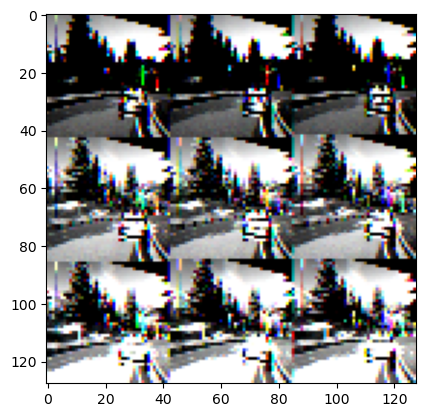

In [48]:
print(over_data[0][0][0].shape)
plt.imshow(over_data[0][0][0].view(128,128,3))
plt.show()
#cv2.imshow('Window',over_data[0][0][0])
#cv2.waitKey(0)
#cv2.destroyAllWindows()

### 2 Defining Neural Network

In [49]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [50]:
mynet= MyModel_CNN().to(device)
print(mynet)

MyModel_CNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (extra): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (predict): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(

In [51]:
#mynet.apply(init_weights)

In [52]:
total_params = sum(p.numel() for p in mynet.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in mynet.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} trainable parameters.')

2,486,467 total parameters.
2,486,467 trainable parameters.


### 3 Training Neural network

In [53]:
mycriterion = nn.MSELoss(reduction='mean') 
myoptimizer = optim.Adam(mynet.parameters(), lr=1e-6, eps = 1e-08) 

In [54]:
def run_epoch(model,criterion,optimizer,dataloader,iftrain):    
    running_loss1 = 0.0  
    running_loss2 = 0.0
    running_loss3 = 0.0  
    #running_loss4 = 0.0
    #running_loss5 = 0.0
    #Iterating through the minibatches of the data
    for i, data in enumerate(dataloader, 0):
        X, y1, y2, y3 = data
        X = [x.cuda() for x in X]
        y1 = y1.to(device).float()
        y2 = y2.to(device).float()
        y3 = y3.to(device).float()
        #y4 = y4.to(device).float()
        #y5 = y5.to(device).float()
        #Y = [y.cuda() for y in Y]
        #X = torch.tensor(X)
        #Y = torch.as_tensor(np.array(Y))
        #print(X.shape)
        if iftrain:  
            optimizer.zero_grad()
            y_pred = model(X)
            y_pred1 = y_pred[:,0].float()
            y_pred2 = y_pred[:,1].float()
            y_pred3 = y_pred[:,2].float()
            #y_pred4 = y_pred[:,3].float()
            #y_pred5 = y_pred[:,4].float()
            loss1 = criterion(y_pred1, y1)
            loss2 = criterion(y_pred2, y2) 
            loss3 = criterion(y_pred3, y3)
            #loss4 = criterion(y_pred4, y4) 
            #loss5 = criterion(y_pred5, y5) 
            loss = loss1 + loss2 + loss3 #+ (loss4 + loss5)
            #print(y)
            #print(y_pred)
            loss.backward()             
            optimizer.step()            
            running_loss1 += loss1.item() 
            running_loss2 += loss2.item() 
            running_loss3 += loss3.item() 
            #running_loss4 += loss4.item() 
            #running_loss5 += loss5.item()
            #print('x', X[1])
            #print('prediction', y_pred1)
            #print('gt', y1)
        else:
            y_pred = y_pred = model(X)
            y_pred1 = y_pred[:,0].float()
            y_pred2 = y_pred[:,1].float()
            y_pred3 = y_pred[:,2].float()
            #y_pred4 = y_pred[:,3].float()
            #y_pred5 = y_pred[:,4].float()
            loss1 = criterion(y_pred1, y1)
            loss2 = criterion(y_pred2, y2)
            loss3 = criterion(y_pred3, y3)
            #loss4 = criterion(y_pred4, y4) 
            #loss5 = criterion(y_pred5, y5)
            loss = loss1 + loss2 + loss3 #+ (loss4 + loss5)
            running_loss1 += loss1.item() 
            running_loss2 += loss2.item() 
            running_loss3 += loss3.item() 
            #running_loss4 += loss4.item() 
            #running_loss5 += loss5.item()
    return running_loss1, running_loss2, running_loss3 #, running_loss4, running_loss5

In [55]:
# test if the model will overfit with only one sample
max_epochs = 300
train_history = np.empty([0, 3], dtype=float) 
val_history = np.empty([0, 3], dtype=float) 
myoptimizer = optim.Adam(mynet.parameters(), lr=1e-4, eps = 1e-08) 
#scheduler = optim.lr_scheduler.CosineAnnealingLR(myoptimizer, max_epochs)
for epoch in range(max_epochs): 
    '''
    if epoch >= 1999 and epoch <= 2999:
        myoptimizer.param_groups[0]['lr'] = 1e-5
    elif epoch > 2999:
        myoptimizer.param_groups[0]['lr'] = 1e-6
    scheduler.step()
    '''
    train_loss1, train_loss2, train_loss3 = run_epoch(model=mynet,criterion=mycriterion,
                           optimizer=myoptimizer,dataloader=over_loader,
                           iftrain=True)
    train_history = np.append(train_history, np.array([[train_loss1, train_loss2, train_loss3]]), axis=0)
    val_loss1, val_loss2, val_loss3 =  run_epoch(model=mynet,criterion=mycriterion,
                           optimizer=myoptimizer,dataloader=over_loader,
                           iftrain=False)
    val_history = np.append(val_history, np.array([[val_loss1, val_loss2, val_loss3]]), axis=0)
    if epoch % 10 == 9:
        print(f"Epoch {epoch + 1}/{max_epochs}")
        print('Delta X: train_loss: %2e, val_loss: %2e'%(train_loss1, val_loss1))
        print('Delta Y: train_loss: %2e, val_loss: %2e'%(train_loss2, val_loss2))
        print('Delta yaw: train_loss: %2e, val_loss: %2e'%(train_loss3, val_loss3))
        #print('Throttle: train_loss: %2e, val_loss: %2e'%(train_loss4, val_loss4))
        #print('Steering Angle: train_loss: %2e, val_loss: %2e'%(train_loss5, val_loss5))
        #print(scheduler.get_last_lr())

Epoch 10/300
Delta X: train_loss: 9.901214e+00, val_loss: 1.009201e+01
Delta Y: train_loss: 5.205681e-01, val_loss: 3.771626e-01
Delta yaw: train_loss: 2.002445e+00, val_loss: 1.048156e+00
Epoch 20/300
Delta X: train_loss: 8.297470e-01, val_loss: 5.043494e-01
Delta Y: train_loss: 5.575757e-02, val_loss: 5.181220e-02
Delta yaw: train_loss: 2.738161e-01, val_loss: 1.972685e-01
Epoch 30/300
Delta X: train_loss: 7.736262e-02, val_loss: 1.181224e-01
Delta Y: train_loss: 1.648841e-02, val_loss: 2.007669e-02
Delta yaw: train_loss: 4.067105e-02, val_loss: 5.450166e-02
Epoch 40/300
Delta X: train_loss: 5.194070e-02, val_loss: 2.591261e-02
Delta Y: train_loss: 7.050226e-03, val_loss: 5.766349e-03
Delta yaw: train_loss: 7.365044e-03, val_loss: 9.960744e-03
Epoch 50/300
Delta X: train_loss: 1.335759e-02, val_loss: 1.731818e-02
Delta Y: train_loss: 4.204598e-03, val_loss: 4.295431e-03
Delta yaw: train_loss: 7.662594e-03, val_loss: 8.179639e-03
Epoch 60/300
Delta X: train_loss: 2.893032e-03, val_los

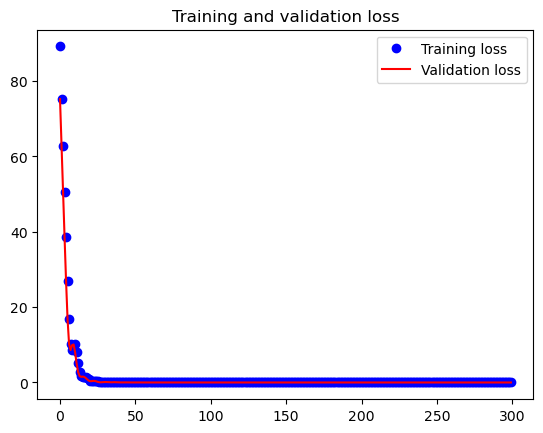

In [56]:
# plot the train&validation loss curve with only one sample
epochs = range(len(train_history))
plt.figure()
plt.plot(epochs, train_history[:,0], 'bo', label='Training loss')
plt.plot(epochs, val_history[:,0], 'r', label='Validation loss')
plt.title('Training and validation loss')

plt.legend()
plt.show()

In [57]:
mynet.eval()
TEST = random.randint (0, 11)
test_in, gt_X, gt_Y, gt_yaw = over_data[TEST]
test_in = [torch.tensor(x).to(device) for x in test_in]
gt_output = [gt_X, gt_Y, gt_yaw]
gt_output = torch.tensor(gt_output)
output_pred = mynet(test_in) 
#print('TEST', TEST)
#print('test_in',test_in[1])
print('prediction:{},\nground truth:{}'.format(output_pred.cpu().detach().numpy(), gt_output))

prediction:[[ 7.5807085  0.9469091 -0.0925535]],
ground truth:tensor([ 7.5807,  0.9469, -0.0926], dtype=torch.float64)


/home/melina/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


In [58]:
# start the main training process

num_trainbatch = np.ceil(len(train_data)/64) 
num_valbatch = np.ceil(len(val_data)/64) 
train_history = np.empty([0, 3], dtype=float) 
val_history = np.empty([0, 3], dtype=float) 

min_loss = 100000
current_patience = 0
patience = 5



In [59]:
myoptimizer = optim.Adam(mynet.parameters(), lr=1e-4, eps = 1e-08) 
max_epochs = 75
print('Start training!')
for epoch in range(max_epochs): 
    
    if epoch >= 50:
        myoptimizer.param_groups[0]['lr'] = 1e-6
    
    
    train_loss1, train_loss2, train_loss3 = run_epoch(model=mynet,criterion=mycriterion,
                           optimizer=myoptimizer,dataloader=train_loader,
                           iftrain=True)
    train_history = np.append(train_history, np.array([[train_loss1, train_loss2, train_loss3]])/num_trainbatch, axis=0)
    val_loss1, val_loss2, val_loss3 =  run_epoch(model=mynet,criterion=mycriterion,
                           optimizer=myoptimizer,dataloader=val_loader,
                           iftrain=False)
    val_history = np.append(val_history, np.array([[val_loss1, val_loss2, val_loss3]])/num_valbatch, axis=0)
    #if epoch % 10 == 9:
    print(f"Epoch {epoch + 1: >3}/{max_epochs}")
    print('Delta X: train_loss: %2e, val_loss: %2e'%(train_history[-1][0], val_history[-1][0]))
    print('Delta Y: train_loss: %2e, val_loss: %2e'%(train_history[-1][1], val_history[-1][1]))
    print('Delta yaw: train_loss: %2e, val_loss: %2e'%(train_history[-1][2], val_history[-1][2]))
    #print('Throttle: train_loss: %2e, val_loss: %2e'%(train_history[-1][3], val_history[-1][3]))
    #print('Steering Angle: train_loss: %2e, val_loss: %2e'%(train_history[-1][4], val_history[-1][4]))
'''
    # early stopping
    if min_loss == 100000 or val_loss < min_loss :
        min_loss = val_loss
        current_patience = 0
        torch.save(mynet.state_dict(),'mynet.pth')
      
    else :
        current_patience += 1 
        if current_patience >= patience :
            print("Stopping early at epoch {}!".format(epoch+1)) 
            break   '''

print('FINISH.')

Start training!
Epoch   1/75
Delta X: train_loss: 4.080118e-01, val_loss: 2.244313e-01
Delta Y: train_loss: 2.871920e-01, val_loss: 9.282596e-02
Delta yaw: train_loss: 4.151458e-02, val_loss: 1.698105e-02
Epoch   2/75
Delta X: train_loss: 8.891197e-02, val_loss: 6.927562e-02
Delta Y: train_loss: 5.399749e-02, val_loss: 4.818684e-02
Delta yaw: train_loss: 1.226494e-02, val_loss: 9.264431e-03
Epoch   3/75
Delta X: train_loss: 5.697049e-02, val_loss: 9.016644e-02
Delta Y: train_loss: 3.079487e-02, val_loss: 3.884441e-02
Delta yaw: train_loss: 7.167931e-03, val_loss: 7.724329e-03
Epoch   4/75
Delta X: train_loss: 4.053725e-02, val_loss: 4.593289e-02
Delta Y: train_loss: 2.142023e-02, val_loss: 2.808859e-02
Delta yaw: train_loss: 4.988898e-03, val_loss: 5.412324e-03
Epoch   5/75
Delta X: train_loss: 3.303052e-02, val_loss: 4.364019e-02
Delta Y: train_loss: 1.590184e-02, val_loss: 3.072684e-02
Delta yaw: train_loss: 3.830926e-03, val_loss: 4.325788e-03
Epoch   6/75
Delta X: train_loss: 2.642

Epoch  45/75
Delta X: train_loss: 3.906841e-03, val_loss: 1.614406e-02
Delta Y: train_loss: 1.862773e-03, val_loss: 8.509610e-03
Delta yaw: train_loss: 2.783634e-04, val_loss: 5.989938e-04
Epoch  46/75
Delta X: train_loss: 4.532361e-03, val_loss: 1.613426e-02
Delta Y: train_loss: 1.713147e-03, val_loss: 7.765919e-03
Delta yaw: train_loss: 2.637721e-04, val_loss: 6.003635e-04
Epoch  47/75
Delta X: train_loss: 6.185835e-03, val_loss: 1.889806e-02
Delta Y: train_loss: 1.756027e-03, val_loss: 8.031816e-03
Delta yaw: train_loss: 2.772500e-04, val_loss: 7.271250e-04
Epoch  48/75
Delta X: train_loss: 5.204247e-03, val_loss: 2.060370e-02
Delta Y: train_loss: 1.578296e-03, val_loss: 7.964382e-03
Delta yaw: train_loss: 2.581172e-04, val_loss: 6.112258e-04
Epoch  49/75
Delta X: train_loss: 4.269873e-03, val_loss: 1.596165e-02
Delta Y: train_loss: 1.418610e-03, val_loss: 8.563059e-03
Delta yaw: train_loss: 2.481552e-04, val_loss: 6.010006e-04
Epoch  50/75
Delta X: train_loss: 3.915160e-03, val_los

KeyboardInterrupt: 

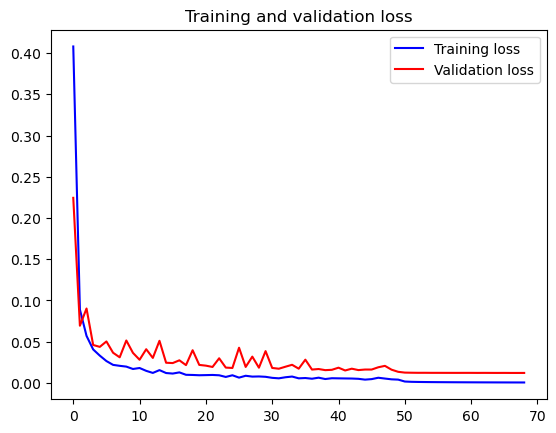

In [60]:
# plot the train&validation loss curve 
epochs = range(len(train_history))
plt.figure()
plt.plot(epochs, train_history[:,0], 'b', label='Training loss')
plt.plot(epochs, val_history[:,0], 'r', label='Validation loss')
plt.title('Training and validation loss')

plt.legend()
plt.show()


In [61]:
# save trained model
torch.save(mynet.state_dict(),'./models/mynet_alex_3outs_5.pth')

In [21]:
mynet.load_state_dict(torch.load('./models/mynet_alex_3outs_3.pth'))

<All keys matched successfully>

In [73]:
for i in range (21):
    TEST = random.randint (0, 1000)
    #TEST = 11730
    test_in, gt_X, gt_Y, gt_yaw = train_data[TEST]
    test_in = [torch.tensor(x).cuda() for x in test_in]
    gt_output = [gt_X, gt_Y, gt_yaw]
    gt_output = torch.tensor(gt_output).to(device)
    output_pred = mynet(test_in) 
    #print('TEST', TEST)
    #print('test_in',test_in)
    print('prediction:{}, ground truth:{}'.format(output_pred[0].cpu().detach().numpy(), gt_output.cpu().detach().numpy()))

prediction:[ 7.5538344   0.988171   -0.07633627], ground truth:[ 7.53253619  0.9876367  -0.08074934]
prediction:[ 6.291609  -0.1541007 -0.0240588], ground truth:[ 6.2984567  -0.14344081 -0.04127873]
prediction:[ 3.3452506  -2.1171696  -0.19679543], ground truth:[ 3.3778707  -2.20776887 -0.21115779]
prediction:[ 8.997821   -0.0179459   0.01040154], ground truth:[ 8.9918098  -0.01295855  0.01493061]
prediction:[ 6.8013096  -2.1763065  -0.23402187], ground truth:[ 6.82200866 -2.17488196 -0.22092736]
prediction:[12.28836    -2.2164004  -0.08640214], ground truth:[12.28002954 -2.2065138  -0.08842498]
prediction:[ 7.5411696   0.36857325 -0.01484141], ground truth:[ 7.57294393  0.39588431 -0.01572311]
prediction:[13.253615    0.35646886  0.04969422], ground truth:[13.25570729  0.35465058  0.04363257]
prediction:[7.56348    0.64734596 0.05664213], ground truth:[7.56145361 0.64249796 0.05928006]
prediction:[1.4285031e+01 2.9323742e-02 5.7534948e-03], ground truth:[1.43050179e+01 5.55064620e-02 

/home/melina/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


In [34]:
for i in range (21):
    #TEST = random.randint (0, 2900)
    test_in, gt_X, gt_Y, gt_yaw, gt_th, gt_st = val_data[TEST]
    test_in = [torch.tensor(x).cuda() for x in test_in]
    gt_output = [gt_X, gt_Y, gt_yaw, gt_th, gt_st]
    gt_output = torch.tensor(gt_output).to(device)
    output_pred = mynet(test_in) 
    #print('TEST', TEST)
    #print('test_in',test_in)
    print('prediction:{}, ground truth:{}'.format(output_pred[:,:3].cpu().detach().numpy(), gt_output[:3].cpu().detach().numpy()))

IndexError: list index out of range

In [69]:
torch.cat((output_pred[0][:3], torch.tensor([1,2]).to(device)), axis = 0)

tensor([11.8419,  0.3709,  0.0354,  1.0000,  2.0000], device='cuda:0',
       grad_fn=<CatBackward0>)

In [67]:
torch.tensor([1]).shape

torch.Size([1])